In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold
import lightgbm as lgbm

import matplotlib.pyplot as plt

In [20]:
train_data = pd.read_csv('./msbd5001-spring-2022/train.csv')
train_data=train_data.fillna(train_data.median())
print(train_data.shape)

(87, 13)


In [21]:
test_data = pd.read_csv('./msbd5001-spring-2022/test.csv')
test_data=test_data.fillna(test_data.median())
print(test_data.shape)

(59, 12)


In [22]:
X=np.array(train_data.iloc[:,:-1])
Y=np.array(train_data.loc[:,"label"])
print("Shape of x:", X.shape)
print("Shape of y:", Y.shape)

Shape of x: (87, 12)
Shape of y: (87,)


In [23]:
# splitting the dataset into train and validation

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 2022)

In [24]:
# checking the new shapes
print("Shape of x_train: ", x_train.shape)
print("Shape of x_val: ", x_val.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)

Shape of x_train:  (69, 12)
Shape of x_val:  (18, 12)
Shape of y_train:  (69,)
Shape of y_val:  (18,)


In [25]:
# Data preprocessing for model validation Part
# performing standard scaling on the data for better fit
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)

In [26]:
# Data preprocessing for Get best_model Part
## Label imbalance
x_train_all, y_train_all = X, Y

## Label balance--SMOTE
#x_train_all, y_train_all = rus.fit_resample(x_train_all, y_train_all)

# performing standard scaling on the data for better fit
sc = StandardScaler()

x_train_all = sc.fit_transform(x_train_all)

In [27]:
# Data preprocessing for Test Part
# performing standard scaling on the data for better fit
sc = StandardScaler()

x_test_new = sc.fit_transform(test_data)

## RandomForest

In [46]:
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=8,
        )

n_estimators = [50, 100, 500]
max_depth=[2,4,8,16]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
kflod = StratifiedKFold(n_splits=5, shuffle=True,random_state=0)
grid_search = GridSearchCV(clf,param_grid,scoring='neg_log_loss',n_jobs=-1,cv=kflod)
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f with: %r" % (mean, param))

Best: -0.302136 using {'max_depth': 16, 'n_estimators': 50}
-0.321740 with: {'max_depth': 2, 'n_estimators': 50}
-0.323479 with: {'max_depth': 2, 'n_estimators': 100}
-0.314852 with: {'max_depth': 2, 'n_estimators': 500}
-0.306848 with: {'max_depth': 4, 'n_estimators': 50}
-0.329360 with: {'max_depth': 4, 'n_estimators': 100}
-0.318659 with: {'max_depth': 4, 'n_estimators': 500}
-0.731443 with: {'max_depth': 8, 'n_estimators': 50}
-0.745963 with: {'max_depth': 8, 'n_estimators': 100}
-0.317785 with: {'max_depth': 8, 'n_estimators': 500}
-0.302136 with: {'max_depth': 16, 'n_estimators': 50}
-0.306723 with: {'max_depth': 16, 'n_estimators': 100}
-0.311620 with: {'max_depth': 16, 'n_estimators': 500}


In [47]:
clf = RandomForestClassifier(
            n_estimators=grid_search.best_params_['n_estimators'],
            max_depth=grid_search.best_params_['max_depth'],
        )
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=50)

In [48]:
pred = clf.predict(x_val)

In [49]:
from sklearn.metrics import roc_auc_score,accuracy_score

# score of the model
auc_result = roc_auc_score(y_val, pred)
print("The Area Under the ROC Curve is", auc_result)
# score of the model
acc_result = accuracy_score(y_val, pred)
print("The accuracy is", acc_result)

The Area Under the ROC Curve is 0.7857142857142857
The accuracy is 0.8333333333333334


/Users/joyhe/anaconda3_2020_07/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


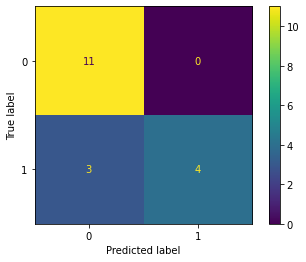

In [50]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, x_val, y_val)

### Get RF_best_model.pickle

In [51]:
model_all = RandomForestClassifier(
            n_estimators=grid_search.best_params_['n_estimators'],
            max_depth=grid_search.best_params_['max_depth'],
        )

model_all.fit(x_train_all, y_train_all)

RandomForestClassifier(max_depth=16, n_estimators=50)

In [52]:
import pickle 

with open('RF_best_model.pickle', 'wb') as f:
    pickle.dump(model_all, f)

### Test

In [53]:
import pickle 

with open('RF_best_model.pickle', 'rb') as f:
    model_test = pickle.load(f)
    y_pred_new = model_test.predict(x_test_new)

In [54]:
# Output submission results
df_submission = pd.read_csv('./msbd5001-spring-2022/sample_submission.csv')
df_submission['label'] = [int(round(x)) for x in y_pred_new]
df_submission["id"]=[int(x) for x in df_submission["id"]]
df_submission.to_csv('submission.csv', index=None)